# Naive approach xgboost + optuna - random forest

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "xgboost_random_forest_optuna"
data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

# drop id
df_train.drop('id', axis=1, inplace=True)

df_train['date'] = pd.to_datetime(df_train['date'])

df_train.head(10)

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [13]:
def create_features(df):
    # split date into year, month, day
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # week number
    df['week_number'] = df['date'].dt.isocalendar().week.astype(int)



    # day of week
    df['dayofweek'] = df['date'].dt.dayofweek

    # weekend
    df['weekend'] = (df['date'].dt.weekday >=4).astype(int)

    # drop date
    df = df.drop('date', axis=1)

    # one-hot encoding of 'country', 'store', 'product' columns
    #df_train = pd.get_dummies(df_train, columns=['country', 'store', 'product'])


    df['country'] = df['country'].astype('category')
    df['store'] = df['store'].astype('category')
    df['product'] = df['product'].astype('category')

    return df

df_train_0 = create_features(df_train)

model_features = ['country', 'store', 'product', 'year', 'month', 'day', 'week_number', 'dayofweek', 'weekend']

df_train_0.head(10)

,country,store,product,num_sold,year,month,day,week_number,dayofweek,weekend
0,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,1,52,6,1
1,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,1,52,6,1
2,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,2017,1,1,52,6,1
3,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,2017,1,1,52,6,1
4,Argentina,Kaggle Learn,Using LLMs to Write Better,49,2017,1,1,52,6,1
5,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88,2017,1,1,52,6,1
6,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98,2017,1,1,52,6,1
7,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14,2017,1,1,52,6,1
8,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83,2017,1,1,52,6,1
9,Argentina,Kaggle Store,Using LLMs to Write Better,69,2017,1,1,52,6,1


In [14]:
df_train_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   country      136950 non-null  category
 1   store        136950 non-null  category
 2   product      136950 non-null  category
 3   num_sold     136950 non-null  int64   
 4   year         136950 non-null  int32   
 5   month        136950 non-null  int32   
 6   day          136950 non-null  int32   
 7   week_number  136950 non-null  int32   
 8   dayofweek    136950 non-null  int32   
 9   weekend      136950 non-null  int32   
dtypes: category(3), int32(6), int64(1)
memory usage: 4.6 MB


Function by which submissions are scored is SMAPE:

In [15]:
def SMAPE(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [16]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

import xgboost as xgb
import optuna

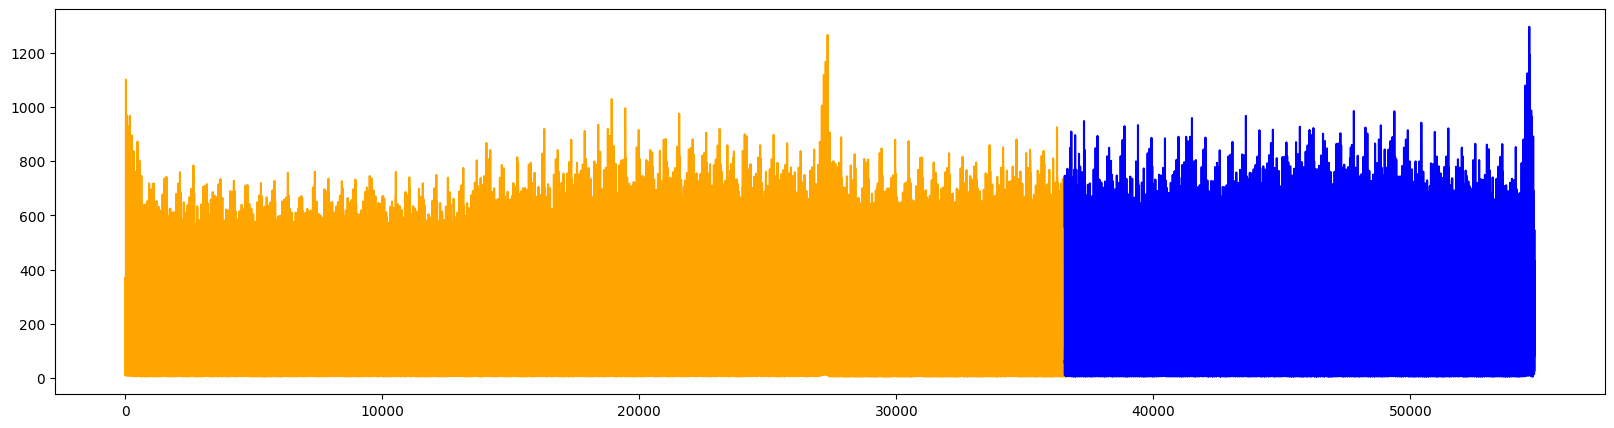

In [17]:
# get small split of data for hyperparameter tuning

train_index, val_index = [ x for x in TimeSeriesSplit(n_splits=2).split(df_train_0[ df_train_0['year'] >= 2020 ]) ][1]

X_train = df_train_0.iloc[train_index][model_features]
y_train = df_train_0.iloc[train_index]['num_sold']

X_val = df_train_0.iloc[val_index][model_features]
y_val = df_train_0.iloc[val_index]['num_sold']

# plot X_train and X_val
plt.figure(figsize=(20, 5))
plt.plot(X_train.index, y_train, color="orange", label='train')
plt.plot(X_val.index, y_val, color="blue", label='val')
plt.show()

In [18]:
def objective(trial):
    model=xgb.XGBRegressor(
        tree_method="gpu_hist", enable_categorical=True,
        learning_rate = 1, max_depth = 5,
        objective = "reg:squarederror",
        colsample_bynode = trial.suggest_float("colsample_bynode", 0.1, 0.9),
        subsample = trial.suggest_float("subsample", 0.1, 0.9),
        num_parallel_tree = trial.suggest_int("num_parallel_tree", 20, 1000),
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[( X_train, y_train), ( X_val, y_val)],
        verbose=False
    )

    return SMAPE(y_val, np.round(model.predict(X_val)))


#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=50)

#best_hyperparams = study.best_params

In [19]:
best_hyperparams = {'colsample_bynode': 0.4,
 'subsample': 0.5,
 'num_parallel_tree': 470} # study.best_params

In [20]:
best_hyperparams

{'colsample_bynode': 0.42, 'subsample': 0.52, 'num_parallel_tree': 474}

In [23]:
# split into train and validation


results_smape = []
results_r2 = []
results_mse = []


N_SPLITS = 5

for train_index, val_index in TimeSeriesSplit(n_splits=N_SPLITS).split(df_train_0):
    X_train = df_train_0.iloc[train_index][model_features]
    y_train = df_train_0.iloc[train_index]['num_sold']

    X_val = df_train_0.iloc[val_index]
    y_val = df_train_0.iloc[val_index]['num_sold']
      
    model = xgb.XGBRegressor(tree_method="hist", enable_categorical=True, **best_hyperparams)
    model.fit(X_train, y_train)

    # evaluate on validation set
    y_pred = np.round(model.predict(X_val[model_features]))

    smape = SMAPE(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    results_smape.append(smape)
    results_r2.append(r2)
    results_mse.append(mse)
    del model

print("Cross validated results:")

print("SMAPE: %s" % results_smape)
print("R2: %s" % results_r2)
print("MSE: %s" % results_mse)

print("Mean results:")
print("SMAPE: %.4f" % np.mean(results_smape))
print("R2: %.4f" % np.mean(results_r2))
print("MSE: %.4f" % np.mean(results_mse))

# add a row with results to csv file leaderboard.csv

row = [model_name, np.mean(results_smape), np.mean(results_r2), np.mean(results_mse)]
with open('leaderboard.csv', 'a') as fd:
    import csv
    fd.write('\n')
    writer = csv.writer(fd, delimiter=',', lineterminator=';\n')
    writer.writerow(row)

KeyboardInterrupt: 

In [ ]:
# train on full data
X_train = df_train_0.drop('num_sold', axis=1)
y_train = df_train_0['num_sold']

model = xgb.XGBRegressor(tree_method="hist", enable_categorical=True, **best_hyperparams)
model.fit(X_train[model_features], y_train)

In [ ]:
X_train['date'] = pd.to_datetime(X_train['year'].astype(str) + '-' + X_train['month'].astype(str) + '-' + X_train['day'].astype(str))
X_val['date'] = pd.to_datetime(X_val['year'].astype(str) + '-' + X_val['month'].astype(str) + '-' + X_val['day'].astype(str))

# sort by date
X_train.sort_values(by='date', inplace=True)
X_val.sort_values(by='date', inplace=True)

# plot 'num_sold' vs 'date'
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(X_train['date'], y_train, label='train', color='lightblue')
ax.plot(X_val['date'], y_val, label='validation', color='red')

ax.set_xlabel('date')
ax.set_ylabel('num_sold')

ax.legend()
plt.show()

In [ ]:
df_val = X_val.copy()
df_val['actual'] = y_val
df_val['prediction'] = model.predict(df_val[model_features])
df_val['prediction'] = df_val['prediction'].astype(int)
df_val

In [ ]:
# test 

df_test = pd.read_csv(data_path + "test.csv")

df_test['date'] = pd.to_datetime(df_test['date'])

df_test = create_features(df_test)
# predict for test set

df_test['prediction'] = model.predict(df_test[model_features])
df_test['prediction'] = df_test['prediction'].astype(int)
df_test

In [ ]:
df_test['num_sold'] = df_test['prediction']
df_test[['id', 'num_sold']].to_csv(f'{model_name}_submission.csv', index=False)